Here we I will show how to analyse the primordial feature chains

# Importing libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from postprocessing import *
import os

The main object we will be using to analyse the chains is the posterior binned along the frequency axis. I will start specifying a few parameters:

In [33]:
chain,logprob = get_total_chain('PrimFeature_lin_tutorial_range2',2,0.5,10)

chains/PrimFeature_lin_tutorial_range2_Run_0.h5
chains/PrimFeature_lin_tutorial_range2_Run_1.h5


We save the combined chain:

In [34]:
with h5.File('chains/PrimFeature_lin_tutorial_range2_total.h5', 'w') as out_f:
    save_dataset(out_f,'chain',chain)
    save_dataset(out_f,'logprob',logprob)

Let us take a look at the posterior for a specific freq. range:

In [37]:
handle_list = ['chains/PrimFeature_lin_tutorial_range1_total.h5','chains/PrimFeature_lin_tutorial_range2_total.h5']
range_limits = [[100,400],[400,650]]
file_output = 'test.h5'
dir_out = ''
param_map = {'omega':3, 'amplitude':2}
omega_bin = 10

In [38]:
GetBinnedPosterior_1D(handle_list,range_limits,file_output,dir_out, param_map,verbose = False,omega_bin = omega_bin)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [39]:
with h5.File('test.h5','r') as f:
    cred_1sigma = f['A_cred_1sigma'][:]
    cred_2sigma = f['A_cred_2sigma'][:]
    cred_3sigma = f['A_cred_3sigma'][:]

In [42]:
omega_min, omega_max = 100, 650
omega_bins = np.arange(omega_min, omega_max + omega_bin, omega_bin)
omega_ctrs = 0.5 * (omega_bins[1:] + omega_bins[:-1])

Text(0, 0.5, '$P(|A|)<= threshold$')

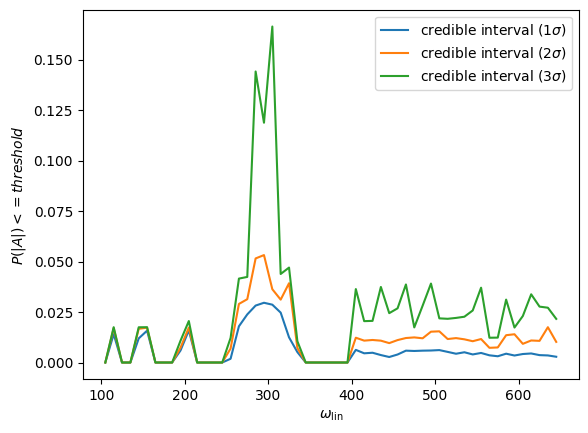

In [43]:
plt.figure()
plt.plot(omega_ctrs,cred_1sigma, label = "credible interval ($1\sigma$)")
plt.plot(omega_ctrs,cred_2sigma, label = "credible interval ($2\sigma$)")
plt.plot(omega_ctrs,cred_3sigma, label = "credible interval ($3\sigma$)")
plt.legend()
plt.xlabel(r'$\omega_{\rm lin}$')
plt.ylabel(r'$P(|A|)<= threshold$')